---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `readonly/train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `readonly/test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32
       
### Hints

* Make sure your code is working before submitting it to the autograder.

* Print out your result to see whether there is anything weird (e.g., all probabilities are the same).

* Generally the total runtime should be less than 10 mins. You should NOT use Neural Network related classifiers (e.g., MLPClassifier) in this question. 

* Try to avoid global variables. If you have other functions besides blight_model, you should move those functions inside the scope of blight_model.

* Refer to the pinned threads in Week 4's discussion forum when there is something you could not figure it out.

In [37]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix as cm

In [38]:
train = pd.read_csv('readonly/train.csv', encoding = "ISO-8859-1")
train = train[train['compliance'].notnull()]
print(train['disposition'].value_counts())

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Responsible by Default                138340
Responsible by Admission               13701
Responsible by Determination            7644
Responsible (Fine Waived) by Deter       195
Name: disposition, dtype: int64


In [39]:
test = pd.read_csv('readonly/test.csv', encoding = "ISO-8859-1")
print(test['disposition'].value_counts())

Responsible by Default                51602
Responsible by Admission               4484
Responsible by Determination           4124
Responsible (Fine Waived) by Deter      781
Responsible - Compl/Adj by Default        6
Responsible - Compl/Adj by Determi        2
Responsible (Fine Waived) by Admis        1
Responsible by Dismissal                  1
Name: disposition, dtype: int64


In [40]:
## data preprocessing 

## one hot encoding 
subset = pd.get_dummies(train.disposition, prefix='disposition')
train = pd.merge(train, subset, left_index=True, right_index=True)

latlons = pd.read_csv('readonly/latlons.csv')
addresses = pd.read_csv('readonly/addresses.csv')
geo = pd.merge(addresses[['ticket_id', 'address']], latlons[['lat', 'lon', 'address']], how='inner', on='address')
## merge with geo data
df = pd.merge(train, geo, how = 'inner', on='ticket_id' )

features_label = ['fine_amount', 'admin_fee', 'state_fee', 'late_fee', 'judgment_amount', 'lat', 'lon', 'disposition_Responsible (Fine Waived) by Deter','disposition_Responsible by Admission','disposition_Responsible by Default','disposition_Responsible by Determination','compliance']
features = ['fine_amount', 'admin_fee', 'state_fee', 'late_fee', 'judgment_amount', 'lat', 'lon', 'disposition_Responsible (Fine Waived) by Deter','disposition_Responsible by Admission','disposition_Responsible by Default','disposition_Responsible by Determination']
added_features = ['disposition_Responsible - Compl/Adj by Default', 'disposition_Responsible - Compl/Adj by Determi', 'disposition_Responsible by Dismissal', 'disposition_Responsible (Fine Waived) by Admis']


df = df[features_label]
## forward fill na lat and lon values 
df['lat'] = df['lat'].fillna(method = 'ffill') 
df['lon'] = df['lon'].fillna(method = 'ffill') 
X = df[features]
for f in added_features:
    X[f] = np.zeros(len(X), dtype = 'uint8')
y = df['compliance']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [41]:
## model testing and validation 
## grid search 

# rfc = RandomForestClassifier(random_state=42)
# param_grid = { 
#     'n_estimators': [70,80,100],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [14,15, None],
#     'criterion' :['gini', 'entropy']
# }

# CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
# CV_rfc.fit(X_train, y_train)
# CV_rfc.best_params_


In [42]:
clf = RandomForestClassifier(n_estimators = 100).fit(X_train, y_train)
predict = clf.predict(X_test)
tn, fp, fn, tp = cm(y_test,predict).ravel()
print(cm(y_test, predict))
print(tn, fp, fn, tp)
print(clf.score(X_test, y_test))

[[36396   682]
 [ 2002   890]]
36396 682 2002 890
0.932849637228


AUC: 0.801


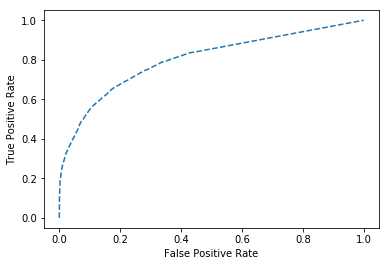

In [43]:
# plot ROC curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

probs = clf.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
fpr, tpr, _ = roc_curve(y_test, probs)
pyplot.plot(fpr, tpr, linestyle='--')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.show()




In [5]:
def blight_model():
    train = pd.read_csv('train.csv', encoding = "ISO-8859-1")
    train = train[train['compliance'].notnull()]
    ## one hot encoding 
    subset = pd.get_dummies(train.disposition, prefix='disposition')
    train = pd.merge(train, subset, left_index=True, right_index=True)

    latlons = pd.read_csv('latlons.csv')
    addresses = pd.read_csv('addresses.csv')
    geo = pd.merge(addresses[['ticket_id', 'address']], latlons[['lat', 'lon', 'address']], how='inner', on='address')

    ## merge with geo data
    df = pd.merge(train, geo, how = 'inner', on='ticket_id' )
    features_label = ['fine_amount', 'admin_fee', 'state_fee', 'late_fee', 'judgment_amount', 'lat', 'lon', 'disposition_Responsible (Fine Waived) by Deter','disposition_Responsible by Admission','disposition_Responsible by Default','disposition_Responsible by Determination','compliance']
    features = ['fine_amount', 'admin_fee', 'state_fee', 'late_fee', 'judgment_amount', 'lat', 'lon', 'disposition_Responsible (Fine Waived) by Deter','disposition_Responsible by Admission','disposition_Responsible by Default','disposition_Responsible by Determination']
    added_features = ['disposition_Responsible - Compl/Adj by Default', 'disposition_Responsible - Compl/Adj by Determi', 'disposition_Responsible by Dismissal', 'disposition_Responsible (Fine Waived) by Admis']

    df = df[features_label]
    ## forward fill na lat and lon values 
    df['lat'] = df['lat'].fillna(method = 'ffill') 
    df['lon'] = df['lon'].fillna(method = 'ffill') 
    X = df[features]
    for f in added_features:
        X[f] = np.zeros(len(X), dtype = 'uint8')
    y = df['compliance']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
    clf = RandomForestClassifier(n_estimators = 100).fit(X_train, y_train)

    df_test = pd.read_csv('test.csv', encoding = "ISO-8859-1")
    ## testset feature space
    features_test = features + added_features
    ## one hot encoding
    subset_test = pd.get_dummies(df_test.disposition, prefix='disposition') 
    df_test = pd.merge(df_test, subset_test, left_index=True, right_index=True) 
    ## merge with geo data
    df_test = pd.merge(df_test, geo, how = 'inner', on='ticket_id' )
    ## forward fill na lat and lon values
    df_test['lat'] = df_test['lat'].fillna(method = 'ffill') 
    df_test['lon'] = df_test['lon'].fillna(method = 'ffill') 

    df_test.index = df_test['ticket_id']
    X_predict = clf.predict_proba(df_test[features_test])
    return pd.Series(data = X_predict[:,1], index = df_test['ticket_id'])

blight_model()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2827: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


ticket_id
284932    0.020000
285362    0.000000
285361    0.000000
285338    0.130000
285346    0.000000
285345    0.110000
285347    0.021667
285342    0.820000
285530    0.132667
284989    0.010000
285344    0.000000
285343    0.000000
285340    0.000000
285341    0.134167
285349    0.000000
285348    0.010000
284991    0.000000
285532    0.080000
285406    0.000000
285001    0.000000
285006    0.000000
285405    0.000000
285337    0.000000
285496    0.000000
285497    0.020000
285378    0.000000
285589    0.000000
285585    0.000000
285501    0.151667
285581    0.290000
            ...   
376367    0.000000
376366    0.160000
376362    0.080000
376363    0.640000
376365    0.000000
376364    0.160000
376228    0.780000
376265    0.007500
376286    0.470000
376320    0.020000
376314    0.000000
376327    0.790000
376385    0.150000
376435    0.870000
376370    0.990000
376434    0.010000
376459    0.000000
376478    0.000000
376473    0.000000
376484    0.050000
376482    0.000000
37